# *Object Localization using mnist dataset using Tensorflow*

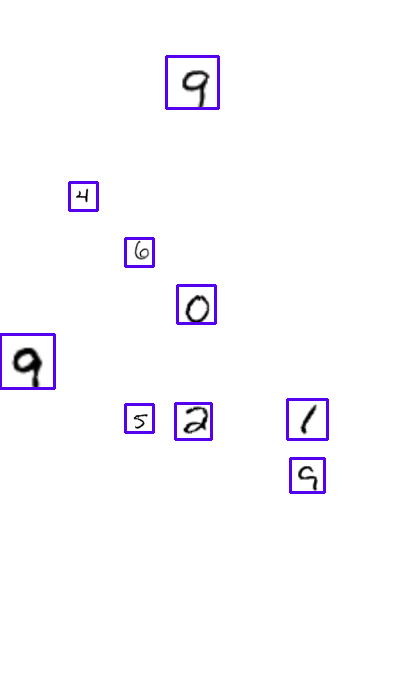

### *Lets Load the necessary libraries for this notebook*

In [ ]:
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow.keras as ks

## *we'll make use of GPU for training our model*

In [ ]:
gpus = tf.config.experimental.list_logical_devices('GPU')

strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
print("running on gpu", [gpu.name for gpu in gpus])

## *Load the dataset and from the tensorflow datasets*

In [ ]:
batch_size = 64 * strategy.num_replicas_in_sync


def get_training_dataset():
    with strategy.scope():
        dataset = tfds.load('mnist', split='train', as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat()
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(-1)

    return dataset

def get_validation_dataset():
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    #dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

    
    return dataset

## *creating our own bounding box by placing the images randomly on a 75x75 image*

In [ ]:
def read_image_tfds(image, label):
    
    xmin = tf.random.uniform((), 0, 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0, 48, dtype=tf.int32)
    image = tf.reshape(image, (28, 28, 1,))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32)/255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)
    xmax = (xmin+28)/75
    ymax = (ymin+28)/75
    xmin = xmin/75
    ymin = ymin/75
    
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])   
    

In [ ]:
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
    
    batch_train_ds = training_dataset.unbatch().batch(N)
    
    if tf.executing_eagerly():

        for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:

            validation_digits = validation_digits.numpy()
            validation_labels = validation_labels.numpy()
            validation_bboxes = validation_bboxes.numpy()
            break

        for training_digits, (training_labels, training_bboxes) in batch_train_ds:
            training_digits = training_digits.numpy()
            training_labels = training_labels.numpy()
            training_bboxes = training_bboxes.numpy()
            break
    
    validation_labels = np.argmax(validation_labels, axis=1)
    training_labels = np.argmax(training_labels, axis=1)

    return (training_digits, training_labels, training_bboxes, 
           validation_digits, validation_labels, validation_bboxes)

In [ ]:


with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()


(training_digits, training_labels, training_bboxes, 
validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset,
                                                                                 validation_dataset, 10)


## *Lets Visualize a number of images in random with the bounding box*

In [ ]:
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

    n = 10

    indexes = np.random.choice(len(predictions), size=n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]

    n_iou = []
    if len(iou) > 0:
        n_iou = iou[indexes]

    if (len(pred_bboxes) > 0):
        n_pred_bboxes = pred_bboxes[indexes,:]

    if (len(bboxes) > 0):
        n_bboxes = bboxes[indexes,:]


    n_digits = n_digits * 255.0
    n_digits = n_digits.reshape(n, 75, 75)
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(10):
        ax = fig.add_subplot(1, 10, i+1)
        bboxes_to_plot = []
        if (len(pred_bboxes) > i):
            bboxes_to_plot.append(n_pred_bboxes[i])

        if (len(bboxes) > i):
            bboxes_to_plot.append(n_bboxes[i])

        img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=["true", "pred"])
        plt.xlabel(n_predictions[i])
        plt.xticks([])
        plt.yticks([])

        if n_predictions[i] != n_labels[i]:
            ax.xaxis.label.set_color('red')



        plt.imshow(img_to_draw)

        if len(iou) > i :
            color = "black"
            if (n_iou[i][0] < iou_threshold):
                color = "red"
            ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)



In [ ]:
def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=1, display_str_list=()):
    
    image_pil = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new('RGBA', image_pil.size)
    rgbimg.paste(image_pil)
    
    draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
    
    return np.array(rgbimg)
    

def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=1, display_str_list=()):
    
    boxes_shape = boxes.shape
    
    if not boxes_shape:
        return
    
    if len(boxes_shape)!=2 or boxes_shape[1]!=4:
        raise ValueError('Input must be of size [N, 4]')
    
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3], boxes[i, 2], color[i], thickness, 
                                  display_str_list[i])
        
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color='red', thickness=1, 
                              display_str_list=None, use_normalized_coordinates=True):
    
    draw = PIL.ImageDraw.Draw(image)
    
    im_width, im_height = image.size
    
    if use_normalized_coordinates:
        
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    
    else:
        (left, right, top, bottom) = (xmin, ymin, xmax, ymax)
    
    draw.line([(left, top), (left, bottom),(right, bottom), (right, top), (left, top)], width=thickness, fill=color)
    

In [ ]:
display_digits_with_boxes(training_digits, training_labels, training_labels, np.array([]), 
                         training_bboxes, np.array([]), 'training_digits and their labels')

display_digits_with_boxes(validation_digits, validation_labels, validation_labels, np.array([]), 
                          validation_bboxes, np.array([]), 'validation_digits and their labels' )

## *We'll create a multiple output model which would be able to classify the image as well predict the bounding box*

In [ ]:
def feature_extractor(inputs):
    
    x = ks.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(75, 75, 1))(inputs)
    x = ks.layers.AveragePooling2D((2, 2))(x)
    x = ks.layers.Conv2D(32, activation='relu', kernel_size=3)(x)
    x = ks.layers.AveragePooling2D((2, 2))(x)
    x = ks.layers.Conv2D(64, activation='relu', kernel_size=3)(x)
    x = ks.layers.AveragePooling2D((2, 2))(x)
    return x

def dense_layer(inputs):
    x = ks.layers.Flatten()(inputs)
    x = ks.layers.Dense(128, activation='relu')(x)
    return x

def classifier(inputs):
    classifier_output = ks.layers.Dense(10, activation='softmax',name='classifier')(inputs)
    return classifier_output

def bounding_box_regression(inputs):
    bounding_box_regression_output = ks.layers.Dense(units='4', name='bounding_box')(inputs)
    
    return bounding_box_regression_output

def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layer(feature_cnn)
    classification_output = classifier(dense_output)
    bounding_box = bounding_box_regression(dense_output)
    
    model = ks.Model(inputs=inputs, outputs=[classification_output, bounding_box])
    
    return model

def define_and_compile_model(inpust):
    
    model = final_model(inputs)
    model.compile(optimizer='adam', loss={
        'classifier': 'categorical_crossentropy', 
        'bounding_box': 'mse'
    }, 
                  metrics={
                     'classifier':'acc',
                     'bounding_box': 'mse'   
                         })
    return model

## *Let's create the model and compile it*

In [ ]:
with strategy.scope():
    inputs = tf.keras.layers.Input(shape=(75, 75, 1,))
    model = define_and_compile_model(inputs)
model.summary()

## *Training the model*

In [ ]:
steps_per_epoch = 60000/(batch_size*5)
validation_steps = 1

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, 
                   validation_steps=1, epochs=40, verbose=0)

## *Evaluating the model*

In [ ]:
loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(validation_dataset, steps=1)

## *For knowing how well the bounding box are predicted with respect to the true boxes, the intersection over union formulated function is used*

In [ ]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

## *checking how many boxes are predicted successfully*

In [ ]:
def check_iou(iou, iou_threshold=0.6):
    
    good = 0
    bad = 0
    
    for i in iou:
        if i >= iou_threshold:
            good +=1
            continue
        bad += 1
    return good, bad
            

## *Lets check how the model predicts using the validation data*

In [ ]:
predictions = model.predict(validation_digits, steps=1)
prediction_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

good, bad = check_iou(iou)

print('the number of good bounding box prediction: ', good)
print('the number of bad bounding box prediction: ', bad)

iou_threshold=0.6

## *Visualizing the prediction*

In [ ]:
display_digits_with_boxes(validation_digits, prediction_labels, validation_labels, 
                         predicted_bboxes, validation_bboxes, iou, 'True and Predicted values')

## *Visualizing the models metrics -->to see how it learned*

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.style.use('ggplot')
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.legend([metric_name, f'val_{metric_name}'])
  

In [ ]:
plot_metrics("classifier_loss", "Classification Loss", ylim=2)
plot_metrics("bounding_box_loss", "Bounding Box Loss", ylim=0.025)